# Probabilistic Bayesian inference on used Audis

## 1. About this notebook

This notebook builds a Bayesian network and demonstrates meaningful accuracy predicting some used car data. The workflow roughly breaks down into the following:

- Preparation of dataframes from local .csv files downloaded from Kaggle
- Preparation and clustering of ordinal variables into categorical data. (Bayesnets treat ordinal variables as categorical)
- Manual construction of a DAG, with some consideration for over-/under-fitting
- Performance benchmarking on test data over all variables in the DAG

## 2. A quick rant

If you construct a Bayesian network on a directed acyclic graph (DAG) whose structure is found using a structure searching algorithm, you're not doing probabilistic inference, you're doing probabilistic prediction. That's totally fine, by the way. But it's causally blind, and therefore can not account for its output in real world terms. To infer *why* something is probably true, you need to build the DAG based on a real world understanding of *what causes what* so that you can explain the output. That is, using real-world domain knowledge. For example, "Emma is smart, so this exam was probably difficult **because** she only got a C". This means there's only one (or zero, depending on the data specification) correct DAG that allows you do make valid probabilistic inferences, even though there are many DAGs whose corresponding Bayesian networks yield accurate probabilistic predictions about your system.

To get more serious about the subject of "*why*", you need to go further and do counterfactual causal inference. This means saying why something is probably true based on what *would have* otherwise been the case (the counterfactual). This is more advanced than the work in this notebook.

## 3. Prepare dataframe

In [1]:
import pandas as pd
import numpy as np
import sys
import os

from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.inference import VariableElimination

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

np.set_printoptions(suppress=True)
np.set_printoptions(precision=8)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

/home/trev/repos/bayesian-network-concepts/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# download data, unzip and place csv files into directory
!kaggle datasets download -d adityadesai13/used-car-dataset-ford-and-mercedes
!mkdir csv
!unzip -d csv used-car-dataset-ford-and-mercedes.zip
!rm used-car-dataset-ford-and-mercedes.zip

# focus on audi only for this toy project (code in cells below allows for inclusion of other makes)
!find ./csv -name "*.csv" -not -name "audi.csv" -exec rm {} \;

used-car-dataset-ford-and-mercedes.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  used-car-dataset-ford-and-mercedes.zip
  inflating: csv/audi.csv            
  inflating: csv/bmw.csv             
  inflating: csv/cclass.csv          
  inflating: csv/focus.csv           
  inflating: csv/ford.csv            
  inflating: csv/hyundi.csv          
  inflating: csv/merc.csv            
  inflating: csv/skoda.csv           
  inflating: csv/toyota.csv          
  inflating: csv/unclean cclass.csv  
  inflating: csv/unclean focus.csv   
  inflating: csv/vauxhall.csv        
  inflating: csv/vw.csv              


In [3]:
# insert manufacturer names into "make" column in all csv files (in this case, one file)
path=os.getcwd()+'/csv/'
for file in os.listdir(path):
    df = pd.read_csv(path+file)
    df['make'] = os.path.splitext(file)[0]
    df.to_csv(path+file, index=False)

In [4]:
# concatenate all files into one dataframe
files = ['csv/'+file for file in os.listdir(os.getcwd()+'/csv/')]
dataframe = pd.concat([pd.read_csv(f) for f in files ])

# convert year column to age in years
dataframe['year'] = 2020 - dataframe['year']
dataframe.rename(columns={'year': 'age'}, inplace=True)

# the make and model are deterministically related, so combine them
dataframe['model'] = dataframe['make'] + dataframe['model']
dataframe = dataframe.drop('make', axis=1)

dataframe = dataframe.reset_index(drop=True)

In [5]:
dataframe

,model,age,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,audi A1,3,12500,Manual,15735,Petrol,150,55.4,1.4
1,audi A6,4,16500,Automatic,36203,Diesel,20,64.2,2.0
2,audi A1,4,11000,Manual,29946,Petrol,30,55.4,1.4
3,audi A4,3,16800,Automatic,25952,Diesel,145,67.3,2.0
4,audi A3,1,17300,Manual,1998,Petrol,145,49.6,1.0
...,...,...,...,...,...,...,...,...,...
10663,audi A3,0,16999,Manual,4018,Petrol,145,49.6,1.0
10664,audi A3,0,16999,Manual,1978,Petrol,150,49.6,1.0
10665,audi A3,0,17199,Manual,609,Petrol,150,49.6,1.0
10666,audi Q3,3,19499,Automatic,8646,Petrol,150,47.9,1.4


## 4. Prepare variables

The ordinal variables need to be converted to categorical variables. This can be cumbersome, so the functions get_cluster_bounds() and get_cut_points() can be used to divide these variables into categories without too much manual segmentation.

In [6]:
import kmeans1d

def get_cluster_bounds(pandas_series, n):
    
    """
    Splits a pandas series containing ordinal data into n groups
    Returns Divide a into groups based on 1-d k-means "clustering" algorithm.
    """

    # assign integer representing the cluster to each value in the series
    cluster_numbers, _ = kmeans1d.cluster(pandas_series, n)
    
    # create dataframe for filtering by cluster
    clusters_df = pd.DataFrame(zip(pandas_series, cluster_numbers), columns=[pandas_series.name, 'cluster'])
    
    # for each cluster, find upper and lower bounds
    cluster_bounds = dict()
    for cluster_number in set(cluster_numbers):
    
        df_ = clusters_df[clusters_df['cluster']==cluster_number]
        
        cluster_lower_bound = df_[pandas_series.name].min()
        cluster_upper_bound = df_[pandas_series.name].max()
        
        cluster_name = str(df_[pandas_series.name].min()) + '-' +  str(df_[pandas_series.name].max())
        
        cluster_bounds[cluster_name] = [cluster_lower_bound, cluster_upper_bound]
    
    return cluster_bounds


def get_cut_points(cluster_bounds):

    """
    Splits a dictionary returned by get_cluster_bounds() into cut points.
    """
    
    cluster_bounds_list = list(cluster_bounds.values())
    
    cut_points = [(cluster_bounds_list[i][1] + cluster_bounds_list[i+1][0])/2 for i in range(0, len(cluster_bounds_list)-1)]
    cut_points.insert(0, cluster_bounds_list[0][0])
    cut_points.insert(len(cut_points), cluster_bounds_list[-1][1])

    return cut_points


For example, split the tax variable into 5 groups:

In [7]:
get_cluster_bounds(dataframe['tax'], 5)

{'0-30': [0, 30],
 '115-165': [115, 165],
 '190-240': [190, 240],
 '260-330': [260, 330],
 '515-580': [515, 580]}

If you're familiar with UK road tax, you'll know that there are no cars that cost more than £30 and less than £115 to tax, so these groupings make sense.

Now we need to choose some cut points to divide up the tax variable. get_cut_points() just crudely picks the midpoints between the groupings:

In [8]:
get_cut_points(get_cluster_bounds(dataframe['tax'], 5))

[0, 72.5, 177.5, 250.0, 422.5, 580]

Let's use these functions to define the numerical bins (and their cut points) and give names to the elements of the sample spaces of the resulting categorical variables:

In [9]:
# convenience parameter to denote the number of bins into which to split some of the ordinal variables
num_bins = 3

ordinal_bins = {'price':      get_cut_points(get_cluster_bounds(dataframe['price'], 6)),
                'mileage':    get_cut_points(get_cluster_bounds(dataframe['mileage'], num_bins)),
                'tax':        get_cut_points(get_cluster_bounds(dataframe['tax'], num_bins)),
                'engineSize': get_cut_points(get_cluster_bounds(dataframe['engineSize'], num_bins)),
                'mpg':        get_cut_points(get_cluster_bounds(dataframe['mpg'], num_bins)),
                'age':        get_cut_points(get_cluster_bounds(dataframe['age'], num_bins)),
                }

ordinal_categories = {'price':      get_cluster_bounds(dataframe['price'], 6).keys(),
                      'mileage':    get_cluster_bounds(dataframe['mileage'], num_bins).keys(),
                      'tax':        get_cluster_bounds(dataframe['tax'], num_bins).keys(),
                      'engineSize': get_cluster_bounds(dataframe['engineSize'], num_bins).keys(),
                      'mpg':        get_cluster_bounds(dataframe['mpg'], num_bins).keys(),
                      'age':        get_cluster_bounds(dataframe['age'], num_bins).keys(),
                      }

In [10]:
# inspect the groupings that result from the choice of bins
for key, value in ordinal_categories.items():
    print(key, value)

price dict_keys(['1490-15200', '15250-22340', '22365-30400', '30440-43395', '43475-78000', '78990-145000'])
mileage dict_keys(['1-22427', '22438-57465', '57525-323000'])
tax dict_keys(['0-30', '115-220', '230-580'])
engineSize dict_keys(['0.0-1.6', '1.8-2.5', '2.7-6.3'])
mpg dict_keys(['18.9-44.8', '45.6-60.1', '61.4-188.3'])
age dict_keys(['0-2', '3-5', '6-23'])


Now use pd.cut() to apply the ordinal ---> categorical changes into new copy of the source dataframe:

In [11]:
df = dataframe.copy(deep=True)

# convert ordinal variables to binned categories in dataframe
for node in ordinal_categories.keys():
    df[node] = pd.cut(df[node], ordinal_bins[node], labels=ordinal_categories[node])

df = df[sorted(df.columns)]
df = df.dropna()
df = df.astype('category')

In [12]:
df

,age,engineSize,fuelType,mileage,model,mpg,price,tax,transmission
0,3-5,0.0-1.6,Petrol,1-22427,audi A1,45.6-60.1,1490-15200,115-220,Manual
1,3-5,1.8-2.5,Diesel,22438-57465,audi A6,61.4-188.3,15250-22340,0-30,Automatic
2,3-5,0.0-1.6,Petrol,22438-57465,audi A1,45.6-60.1,1490-15200,0-30,Manual
3,3-5,1.8-2.5,Diesel,22438-57465,audi A4,61.4-188.3,15250-22340,115-220,Automatic
4,0-2,0.0-1.6,Petrol,1-22427,audi A3,45.6-60.1,15250-22340,115-220,Manual
...,...,...,...,...,...,...,...,...,...
10660,6-23,2.7-6.3,Diesel,57525-323000,audi A4,18.9-44.8,1490-15200,230-580,Automatic
10661,6-23,1.8-2.5,Diesel,57525-323000,audi A4,45.6-60.1,1490-15200,115-220,Manual
10662,6-23,0.0-1.6,Petrol,22438-57465,audi A3,45.6-60.1,1490-15200,115-220,Manual
10666,3-5,0.0-1.6,Petrol,1-22427,audi Q3,45.6-60.1,15250-22340,115-220,Automatic


It's a good idea to define the sample spaces of each variable independently of the dataframe itself. This is true for two important reasons:

- because a given dataframe pulled from a SQL database won't necessarily contain all elements of each variable's sample space. (e.g. you may have data on dice rolls, but no 5's appear) 
- the source dataframe will be split into training and test sets later, and there's no reason to assume generally that the variables' samples spaces will be fully spanned in these test/training sets.

Since this workflow is a toy project, I will just define the sample spaces now by taking the unique values in the source dataframe. These definitions will be used to ensure the sample spaces are properly defined in the model building / training stage below.

In [13]:
# define variable sample spaces
sample_spaces = {variable:sorted(df[variable].unique().dropna()) for variable in df.columns}

## 5. Prepare directed acyclic graph (DAG)

I chose used car data because it's a topic I know (just about...) enough about to be able to construct the DAG myself from my real-world knowledge. Each edge is accompanied by a comment explaining the rationale.

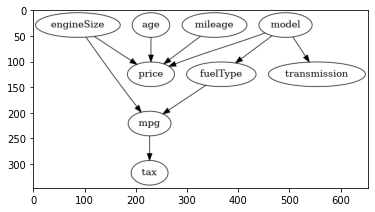

In [14]:
import pygraphviz as pgv
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

dag = pgv.AGraph(directed=True)

for node in df.columns:
    dag.add_node(node)

dag.add_edge('age', 'price')  # "newer cars cost more"
dag.add_edge('mileage', 'price')  # "lower mileage cars cost more"
dag.add_edge('model', 'fuelType')  # "certain car makers are better at making efficient engines"
dag.add_edge('engineSize', 'mpg')  # "bigger engines burn more fuel"
dag.add_edge('engineSize', 'price') # "bigger engine cars are faster, more desirable, and more expensive"
dag.add_edge('mpg', 'tax')  # "gas guzzlers emit more CO2 and incur greater road tax"
dag.add_edge('fuelType', 'mpg') # "diesel tends to be more efficient than petrol"
dag.add_edge('model', 'price')  # "certain brands carry a price premium"
dag.add_edge('model', 'transmission') # "certain brands tend to make more autos e.g. Mercedes"

dag.layout(prog='dot')
dag.draw('dag.png')
img = mpimg.imread('dag.png')

plt.rcParams["figure.figsize"] = (15, 15)
plt.imshow(img)
plt.show()

The graph structure is accessible via the nodes() and edges() methods:

In [15]:
dag.nodes()

['age',
 'price',
 'engineSize',
 'mpg',
 'tax',
 'fuelType',
 'mileage',
 'model',
 'transmission']

In [16]:
dag.edges()

[('age', 'price'),
 ('engineSize', 'price'),
 ('engineSize', 'mpg'),
 ('mpg', 'tax'),
 ('fuelType', 'mpg'),
 ('mileage', 'price'),
 ('model', 'price'),
 ('model', 'fuelType'),
 ('model', 'transmission')]

## 6. Prepare training / test data

Split the dataframe into training and test sets:

In [17]:
train=df.sample(frac=0.8)
test=df.drop(train.index)

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [18]:
len(train)

7510

In [19]:
len(test)

1877

As discussed at the end of section 4, the training and test dataframes will not necessarily contain all elements from all variables' sample spaces, so it's worth checking:

In [20]:
train.nunique() == df.nunique()

age             True
engineSize      True
fuelType        True
mileage         True
model           True
mpg             True
price           True
tax             True
transmission    True
dtype: bool

In [21]:
test.nunique() == df.nunique()

age              True
engineSize       True
fuelType        False
mileage          True
model           False
mpg              True
price           False
tax              True
transmission     True
dtype: bool

## 7. Prepare / train model

Now let's train the pgmpy Bayesian network model using the training dataframe:

In [22]:
model = BayesianNetwork(dag.edges())

# train model with properly defined sample sample_spaces
model.fit(train, state_names=sample_spaces) 
model.check_model()

# class for updating marginals after evidence insertion
infer = VariableElimination(model)

## 8. Model performance

Now let's test the model performance on the test data. There's no explicit need to treat any particular node in a Bayesnet as a target variable. Thus, for this workflow, I'm just going to loop over all variables in the DAG and treat them as the target variable one-by-one. So for each target variable, predict its value by inserting the values of the other entries in that row as evidence, and repeat for every row in the test dataframe. The basic requirement is that the resulting classification performance on the whole test set shows accuracy that exceeds the baseline "pure chance" accuracy, i.e. 1 / (cardinality of target variable).

In [23]:
metrics = pd.DataFrame(columns=['target', 'num_predictions', 'accuracy', 'baseline_accuracy'])

# for all nodes in the DAG...
for target in df.columns:
    
    # create the confusion matrix for this particular target variable 
    confusion_matrix = pd.DataFrame(0, index=sample_spaces[target], columns=sample_spaces[target])
    
    num_predictions=0
    # loop over all rows in the test set and predict the current target variable value
    for idx, row in test.iterrows():
        num_predictions+=1
    
        #evidence_vars = row[row.index.isin(markov_blanket)]
        evidence_vars = row[row.index.isin(test.columns.drop(target))]

        # compile the evidence values for this row
        evidence_for_this_row = dict(zip(evidence_vars.index, evidence_vars.values))
        
        # predict the target variable in this particular row using the pgmpy model
        prediction = infer.map_query(variables=[target],
                                           evidence=evidence_for_this_row,
                                           show_progress=False)[target]
        
        # actual value of target variable in this row
        reality = row[target]    
       
        confusion_matrix.loc[reality, prediction] += 1
        
        # calculate accuracy metrics and populate metrics dataframe
        accuracy = np.diag(confusion_matrix).sum() / confusion_matrix.sum().sum()
        baseline_accuracy = 1/len(sample_spaces[target])
        metrics.loc[len(metrics)] = [target, num_predictions, accuracy, baseline_accuracy]
        
        # progress bar
        j=idx/len(test)
        sys.stdout.write('\r')
        sys.stdout.write(f"predictions for {target} [%-20s] %d%%" % ('='*int(20*j), 100*j))
    sys.stdout.write("\n")

predictions for age [=================== ] 99%
predictions for engineSize [=================== ] 99%
predictions for fuelType [=================== ] 99%
predictions for mileage [=================== ] 99%
predictions for model [=================== ] 99%
predictions for mpg [=================== ] 99%
predictions for price [=================== ] 99%
predictions for tax [=================== ] 99%
predictions for transmission [=================== ] 99%


## 9. Plot performance

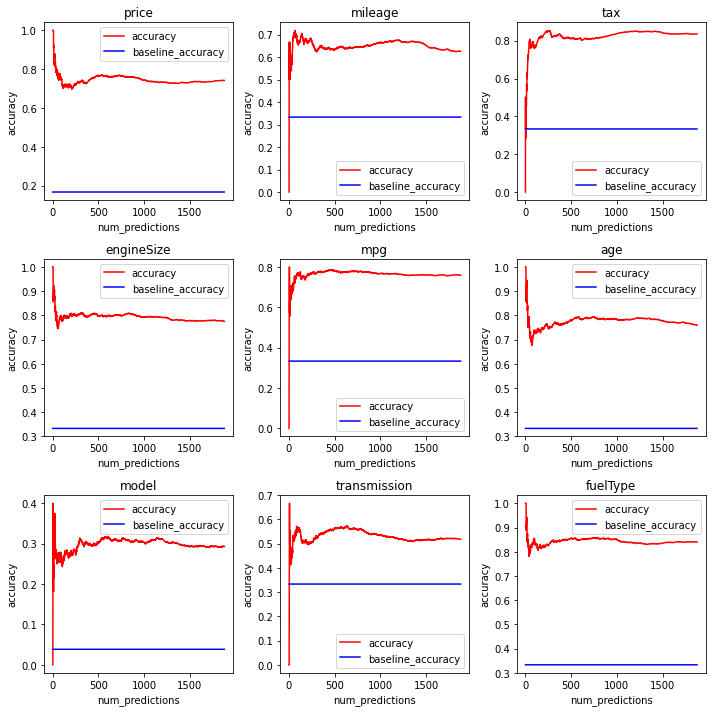

In [24]:
plt.rcParams["figure.figsize"] = [10,10]
fig, ax = plt.subplots(3,3)

plot_idx = {'price': (0,0),
            'mileage': (0,1),
            'tax': (0,2),
            'engineSize': (1,0),
            'mpg': (1,1),
            'age': (1,2),
            'model': (2,0),
            'transmission': (2,1),
            'fuelType': (2,2),
           }

for variable, index in plot_idx.items():
    
    ax[index].set_title(variable)
    
    ax[index].plot(metrics[metrics['target'] == variable]['num_predictions'],
                   metrics[metrics['target'] == variable]['accuracy'],
                   c='red',
                   label='accuracy',
                  )
    
    ax[index].plot(metrics[metrics['target'] == variable]['num_predictions'],
                   metrics[metrics['target'] == variable]['baseline_accuracy'],
                   c='blue',
                   label='baseline_accuracy',
                  )
    
    ax[index].set_xlabel('num_predictions')
    ax[index].set_ylabel('accuracy')
    
    ax[index].legend()

plt.tight_layout()

While the performance is not spectacular, it's clearly above the accuracy you'd expect from pure chance, demonstrating the basic point that Bayesnets display artificial intelligence.